In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("archive.hdf5", 'r')

In [56]:
wl_min = 5590
wl_max = 5610

class Spectrum(object): 
    def __init__(self, wl, fl): 
        wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl[wl_range]
        self.flux = fl[wl_range]

(0, 2)

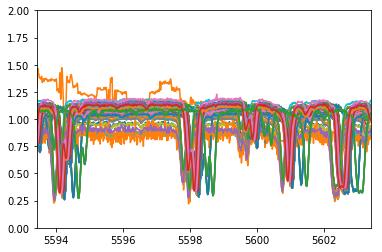

In [24]:
spectra = []

for isot in list(archive): 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)
    
    if sp.flux.max() < 2:
        plt.plot(sp.wavelength, sp.flux)

tio = 5598.410

plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 2])

In [28]:
dx = []
for i in range(1, len(spectra)):
    cross_corr = np.correlate(spectra[0].flux - spectra[0].flux.mean(), 
                              spectra[i].flux - spectra[i].flux.mean(), mode='same')
    
    dx.append(cross_corr.shape[0]//2 - cross_corr.argmax())
#     print(cross_corr.shape[0]//2 - cross_corr.argmax())

(0, 2)

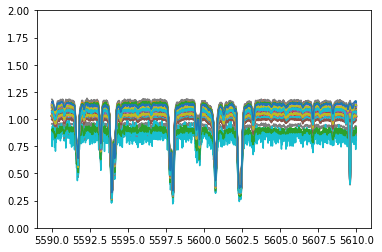

In [39]:
coadded = spectra[0].flux

for i in range(1, len(spectra)): 
    if spectra[i].flux.max() < 1.2:
        rolled_spectrum = np.roll(spectra[i].flux, -dx[i-1])
        plt.plot(spectra[i].wavelength, rolled_spectrum)
        coadded += rolled_spectrum

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 2])

In [45]:
from phoenix import get_any_metallicity_url, get_phoenix_model_wavelengths
from astropy.io import fits

In [65]:
phoenix_wl = get_phoenix_model_wavelengths()
phoenix_fl = fits.getdata(get_any_metallicity_url(5800, 4.5, 0))
phoenix_fl /= phoenix_fl.max()

phoenix_fl = phoenix_fl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]
phoenix_wl = phoenix_wl[(wl_min < phoenix_wl) & (wl_max > phoenix_wl)]

phoenix_fl /= np.median(phoenix_fl)

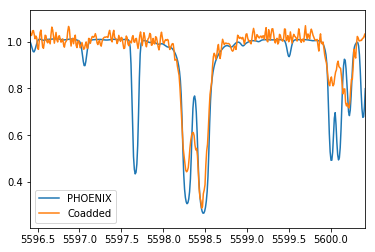

In [66]:
plt.plot(phoenix_wl, phoenix_fl, label='PHOENIX')
plt.plot(spectra[0].wavelength + 0.5, coadded, label='Coadded')
plt.xlim([tio - 2, tio + 2])
plt.legend()